# Chinese characters generator 

In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2DTranspose, Conv2D
from keras.layers.advanced_activations import LeakyReLU

from keras.optimizers import SGD, RMSprop

Using TensorFlow backend.


## Data

In [3]:
filename = "./data/vector300_2hier32x32_24_01_18_19_01_54.txt"

X_vec = []
Y_img = []

img_size = 32
wcount = 0
for line in open(filename):
    vec, img = line[:-1].split(",")
    
    vec = np.array([float(n) for n in vec.split(" ")])
    img = np.array([float(n) / 255 - 127 for n in img.split(" ")])
        
    img = np.reshape(img, (img_size, img_size, 1))
    
    X_vec.append(vec)
    Y_img.append(img)
    
    wcount += 1
    if (wcount % 10000 == 0):
        print("{} words processed".format(wcount))
#     if wcount > 100000:
#         break
        
print("{} words processed".format(wcount))

Y_img = np.array(Y_img)
X_vec = np.array(X_vec)

10000 words processed
20000 words processed
30000 words processed
40000 words processed
50000 words processed
60000 words processed
70000 words processed
80000 words processed
90000 words processed
100000 words processed
110000 words processed
120000 words processed
130000 words processed
140000 words processed
150000 words processed
160000 words processed
170000 words processed
180000 words processed
190000 words processed
200000 words processed
210000 words processed
220000 words processed
230000 words processed
240000 words processed
250000 words processed
260000 words processed
270000 words processed
280000 words processed
290000 words processed
300000 words processed
310000 words processed
320000 words processed
330000 words processed
340000 words processed
350000 words processed
360000 words processed
370000 words processed
380000 words processed
390000 words processed
400000 words processed
410000 words processed
420000 words processed
430000 words processed
440000 words process

In [4]:
Y_img.shape

(461389, 32, 32, 1)

## Visualisation

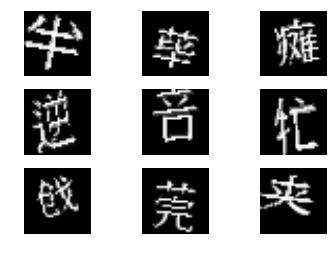

In [5]:
images = Y_img[np.random.randint(0, Y_img.shape[0], 
                                 size=9)]

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(images[i].reshape(img_size, img_size), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

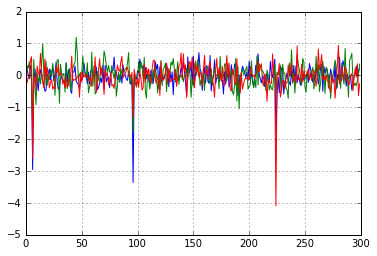

In [6]:
vectors = X_vec[np.random.randint(0, X_vec.shape[0], 
                                  size=3)]

for i in range(3):
    plt.plot(vectors[i])
    
plt.grid()
plt.show()

# GAN
## Generator

In [23]:
gen_dropout = 0.7
gen_input_dim = 4
gen_depth = 512
gen_noise_dim = 300
gen_alpha = 0.3
gen_beta = 0.5

In [24]:
gennet = Sequential()

# Input 
# fully-connected layer
gennet.add(Dense(gen_input_dim * gen_input_dim * gen_depth, 
                 input_dim=gen_noise_dim))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(LeakyReLU(alpha=gen_alpha))
gennet.add(Reshape((gen_input_dim, gen_input_dim, gen_depth)))
gennet.add(Dropout(gen_dropout))

# Deconvolution layers
gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 2), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(LeakyReLU(alpha=gen_alpha))
gennet.add(Dropout(gen_dropout))


gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 4), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(LeakyReLU(alpha=gen_alpha))
gennet.add(Dropout(gen_dropout))


gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 8), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(LeakyReLU(alpha=gen_alpha))
gennet.add(Dropout(gen_dropout))

# Output
gennet.add(Conv2DTranspose(1, 5, padding='same'))
gennet.add(Activation('tanh'))

gennet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16384)             4931584   
_________________________________________________________________
batch_normalization_5 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 4, 4, 1024)        0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 512)         13107712  
__________

## Discriminator

In [25]:
disc_depth = 64
disc_dropout = 0.7
disc_alpha = 0.3

In [26]:
discnet = Sequential()

# Input
discnet.add(Conv2D(disc_depth, 5, strides=2, input_shape=(32, 32, 1), 
                   padding='same'))
discnet.add(LeakyReLU(alpha=gen_alpha))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*2, 5, strides=2, padding='same'))
discnet.add(LeakyReLU(alpha=gen_alpha))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*4, 5, strides=2, padding='same'))
discnet.add(LeakyReLU(alpha=gen_alpha))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*8, 5, strides=2, padding='same'))
discnet.add(LeakyReLU(alpha=gen_alpha))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*16, 5, strides=2, padding='same'))
discnet.add(LeakyReLU(alpha=gen_alpha))
discnet.add(Dropout(disc_dropout))

# Out: scalar estimation of probability
discnet.add(Flatten())
discnet.add(Dense(1))
discnet.add(Activation('sigmoid'))

discnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 256)         819456    
__________

## Discriminator model

In [27]:
discmodel = Sequential()
discmodel.add(discnet)
discmodel.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0002, clipvalue=1.0, decay=6e-8),
                  metrics=['accuracy'])

## Adversarial model

In [28]:
advmodel = Sequential()
advmodel.add(gennet)
advmodel.add(discnet)
advmodel.compile(loss='binary_crossentropy', 
                 optimizer=RMSprop(lr=0.0001, clipvalue=1.0, decay=3e-8),
                 metrics=['accuracy'])

## Training

In [29]:
disc_losses = {"loss": [], "acc": []}
adv_losses = {"loss": [], "acc": []}

In [35]:
batch_size = 256
train_iters = 500
stop_loss = 7.0

log_i = 0

start_time = time.time()

for i in range(train_iters):
    # Get random real images
    images_true = Y_img[np.random.randint(0, 
                                          Y_img.shape[0], 
                                          size=batch_size)]
    # Generate images from noise
    noise = np.random.uniform(-1.0, 1.0, 
                              size=[batch_size, gen_noise_dim])
    images_fake = gennet.predict(noise)
    # Compose training data for discriminator
    x = np.concatenate((images_true, images_fake))
    y = np.concatenate((np.ones((batch_size, 1)), 
                        np.zeros((batch_size, 1))))
    # Train discriminator on composed data
    dics_loss = discmodel.train_on_batch(x, y)
    disc_losses["loss"].append(dics_loss[0])
    disc_losses["acc"].append(dics_loss[1])
    
    # Compose trainig data for adversarial net
    noise = np.random.uniform(-1.0, 1.0, 
                              size=[batch_size, gen_noise_dim])
    y = np.ones([batch_size, 1])
    # Train adversarial net on composed data
    adv_loss = advmodel.train_on_batch(noise, y)
    adv_losses["loss"].append(adv_loss[0])
    adv_losses["acc"].append(adv_loss[1])
    
    # Break if too big losses
#     if dics_loss[0] > stop_loss or adv_loss[0] > stop_loss:
#         print("Too big losses. Disc {:.3f} | Adv {:.3f}".format(dics_loss[0], adv_loss[0]))
#         break
    
    # Print results
    if i % 100 == 0:
        curr_time = time.time()
        if i > 0:
            time_est = (curr_time - start_time) * (train_iters - i) / i
        else:
            time_est = (curr_time - start_time) * train_iters
        time_est_str = str(timedelta(seconds=time_est)).split('.')[0]
        print("{:4d}th batch of {:4d}|".format(i, train_iters) + \
              "Disc loss {:.3f} |Disc acc {:.3f} |Adv loss {:.3f} |Adv acc {:.3}|".format(dics_loss[0], 
                                                                                          dics_loss[1], 
                                                                                          adv_loss[0], 
                                                                                          adv_loss[1]) +\
              "Time est {}".format(time_est_str))

   0th batch of  500|Disc loss 0.000 |Disc acc 1.000 |Adv loss 0.000 |Adv acc 1.0|Time est 0:06:30
 100th batch of  500|Disc loss 0.000 |Disc acc 1.000 |Adv loss 0.000 |Adv acc 1.0|Time est 0:05:17
 200th batch of  500|Disc loss 0.000 |Disc acc 1.000 |Adv loss 0.000 |Adv acc 1.0|Time est 0:03:58
 300th batch of  500|Disc loss 0.000 |Disc acc 1.000 |Adv loss 0.000 |Adv acc 1.0|Time est 0:02:38
 400th batch of  500|Disc loss 0.000 |Disc acc 1.000 |Adv loss 0.000 |Adv acc 1.0|Time est 0:01:19


## Discriminator losses

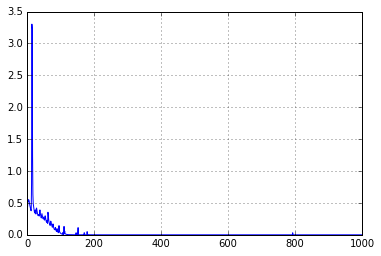

In [36]:
plt.plot(disc_losses["loss"])
plt.grid()

## Adversarial net losses

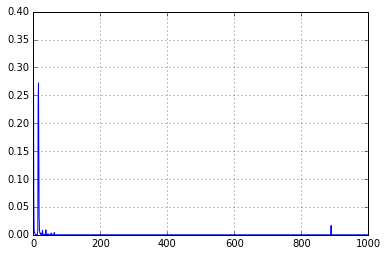

In [37]:
plt.plot(adv_losses["loss"])
plt.grid()

## An attempt to generate images

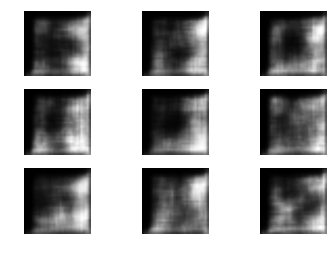

In [38]:
noise = np.random.uniform(-1.0, 1.0, size=[10, gen_noise_dim])
fake_images = gennet.predict(noise)

    
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(fake_images[i].reshape(32, 32), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()